# **ANÁLISIS DE CHURN DE CLIENTES PARA UNA EMPRESA DE TELECOMUNICACIONES**

## Funciones

In [ ]:
# Función imputación de outlier
# ------

def imputar_valores_extremos(df, variable, metodo='media'):
    """
    Imputa valores extremos en una variable de un DataFrame utilizando la media o la mediana.

    Parámetros:
    df (DataFrame): El DataFrame que contiene la variable a imputar.
    variable (str): El nombre de la variable que deseas imputar.
    metodo (str): La forma de imputación ('media' o 'mediana'). Por defecto es 'media'.

    Retorna:
    DataFrame: El DataFrame con la variable imputada.
    """
    if metodo not in ['media', 'mediana']:
        raise ValueError("El método debe ser 'media' o 'mediana'")

    # Calcular la media o la mediana
    if metodo == 'media':
        valor_imputacion = df[variable].mean()
    else:
        valor_imputacion = df[variable].median()

    # Identificar valores extremos (usando una regla de 3 veces la desviación estándar)
    limite_inferior = df[variable].mean() - 3 * df[variable].std()
    limite_superior = df[variable].mean() + 3 * df[variable].std()

    # Imputar valores extremos
    df[variable] = np.where(
        (df[variable] < limite_inferior) | (df[variable] > limite_superior),
        valor_imputacion,
        df[variable]
    )

    return df


# Función imputación perdidos
# ------

def imputar_valores(df, variable, metodo='media', valor_especifico=None):
    """
    Imputa valores perdidos en una columna de un DataFrame según el método especificado.

    Parámetros:
    df (pd.DataFrame): El DataFrame en el que se imputarán los valores.
    variable (str): El nombre de la columna a imputar.
    metodo (str): El método de imputación ('media', 'mediana', 'moda', 'valor_especifico').
    valor_especifico: El valor específico a usar para la imputación (relevante solo si 'metodo' es 'valor_especifico').

    Retorna:
    pd.DataFrame: El DataFrame con la variable imputada.
    """

    if metodo == 'media':
        imputacion = df[variable].mean()
    elif metodo == 'mediana':
        imputacion = df[variable].median()
    elif metodo == 'moda':
        imputacion = df[variable].mode()[0]
    elif metodo == 'valor_especifico':
        if valor_especifico is None:
            raise ValueError("Debe proporcionar un valor específico para la imputación.")
        imputacion = valor_especifico
    else:
        raise ValueError("Método de imputación no reconocido. Use 'media', 'mediana', 'moda' o 'valor_especifico'.")

    df[variable].fillna(imputacion, inplace=True)
    return df


# Funcion graficadora confusion_marix
# ---
def confusion_matrix_graph(cm):
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['No', 'Yes'],
              yticklabels=['No', 'Yes'])
  plt.title('Matriz de Confusión')
  plt.xlabel('Predicción')
  plt.ylabel('Realidad')
  plt.show()


# Funcion ROC curve
# ---
def roc_curve_graph(y,prob):
  # Obtener las probabilidades de la clase positiva
  y_prob = prob[:, 1]  # Probabilidades de la clase 1

  # Calcular la curva ROC
  fpr, tpr, thresholds = roc_curve(y,  y_prob)

  # Calcular el área bajo la curva (AUC)
  roc_auc = auc(fpr, tpr)

  # Graficar la curva ROC
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
  plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
  plt.title('Curva ROC')
  plt.xlabel('Tasa de Falsos Positivos (FPR)')
  plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
  plt.legend(loc='lower right')
  plt.grid()
  plt.show()

## Carga de datos


In [ ]:
#Importamos las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from collections import Counter


In [ ]:
# Creando conexión con google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#Importamos la data
data = pd.read_csv('/gdrive/MyDrive/DMC_2025/4_Met_Sup/sesion_4/Data_Customer_Churn_new.csv',sep = ';')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7562-UXTPG,Female,0,No,No,13,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,70.15,886.70
1,8071-SBTRN,Female,0,No,No,70,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Mailed check,111.15,7737.55
2,1113-IUJYX,Female,0,Yes,No,14,Yes,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,One year,No,Mailed check,105.95,1348.90
3,6668-CNMFP,Female,0,Yes,Yes,19,Yes,Yes,Fiber optic,No,No,No,Yes,No,Yes,One year,Yes,Bank transfer (automatic),89.35,1686.85
4,5626-MGTUK,Female,0,No,No,20,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),89.10,1879.25


Variables consideradas en el analisis

- **customerID**: Identificador único asignado a cada cliente en la base de datos.  
- **gender**: Género del cliente (por ejemplo, masculino o femenino).  
- **SeniorCitizen**: Indica si el cliente es una persona mayor (1 para sí, 0 para no).  
- **Partner**: Indica si el cliente tiene pareja (por ejemplo, "Yes" o "No").  
- **Dependents**: Indica si el cliente tiene personas dependientes.  
- **tenure**: Número de meses que el cliente ha estado con la empresa.  
- **PhoneService**: Indica si el cliente tiene contratado el servicio de teléfono.  
- **MultipleLines**: Indica si el cliente tiene más de una línea telefónica.  
- **InternetService**: Tipo de servicio de Internet contratado por el cliente.  
- **OnlineSecurity**: Indica si el cliente tiene un servicio de seguridad en línea (por ejemplo, "Yes" o "No").  
- **OnlineBackup**: Indica si el cliente tiene contratado un servicio de respaldo en línea.  
- **DeviceProtection**: Indica si el cliente tiene contratado un servicio para la protección de sus dispositivos.  
- **TechSupport**: Indica si el cliente tiene contratado un servicio de soporte técnico.  
- **StreamingTV**: Indica si el cliente tiene acceso a servicios de transmisión de televisión.  
- **StreamingMovies**: Indica si el cliente tiene acceso a servicios de transmisión de películas.  
- **Contract**: Tipo de contrato que tiene el cliente.  
- **PaperlessBilling**: Indica si el cliente utiliza facturación electrónica en lugar de facturas físicas.
- **PaymentMethod**: Método de pago utilizado por el cliente.  
- **MonthlyCharges**: Monto en dólares que el cliente paga mensualmente por los servicios.  
- **TotalCharges**: Monto total que el cliente ha pagado desde el inicio de su contrato.  
- **Churn**: Variable objetivo que indica si el cliente ha abandonado la empresa.  


In [ ]:
data.columns

In [ ]:
# Desarrollar un modelo predictivo para detectar la fuga de clientes de una empresa de telecomunicaciones

# y (variable dependiente) : Churn
# Xs (variables independientes) : Todas menos el Churn, CustomerID

In [ ]:
data.info()

In [ ]:
data.duplicated().sum() #data.drop_duplicated() esta funcion elimina las filas duplicadas de mi dataset

#### Análisis descriptivo de Churn


In [ ]:
data["Churn"].value_counts(normalize = True) * 100 # Diferencia de 66.66666% y 33.333333%

In [ ]:
# visualizando la target
sns.catplot(x='Churn', data=data, kind="count")

In [ ]:
# Modelos de Clasificación

# 1. Limpieza de tu data
# 2. Analisis Descriptivo
# 3. Organizar tu data a formato numerico (variables cualitativas --> numericas (formato))
# 4. Particion de la data (train y test)
# 5. Balanceo de datos
# 6. Ejecucion de modelos
# 7. Optimizacion de hiperparametros

#### Limpieza de datos


In [ ]:
# Separando las variables segun su tipo para un correcta lectura

# Lista de variables numéricas
numeric_vars = data.select_dtypes(include=['number']).columns.tolist()

# Lista de variables categóricas
categorical_vars = data.select_dtypes(include=['object', 'category']).columns.tolist()


In [ ]:
numeric_vars

In [ ]:
categorical_vars

#### Analizando variables numéricas

In [ ]:
data.describe() # describe es una funcion para tener un reporte estadistico basico rapidamente

In [ ]:
data.hist(figsize=(12, 4), layout=(1,3), bins=10)

In [ ]:
# Actualizamos variables numericas

data["SeniorCitizen"] = data["SeniorCitizen"].astype("str")

numeric_vars.remove('SeniorCitizen')
categorical_vars.append('SeniorCitizen')
numeric_vars, categorical_vars

#### Analizando variables categóricas

In [ ]:
# Iterar sobre las columnas del DataFrame
for column in data.columns:
  if data[column].dtype == 'object' or data[column].dtype.name == 'category':
    print(f"Resumen de porcentajes para la variable '{column}':\n")
    print(data[column].value_counts(normalize=True) * 100)
    print("\n" + "-"*50 + "\n")

In [ ]:
# Actualizamos variables categoricas

data["TotalCharges"] = data["TotalCharges"].replace(" ",np.nan)
data["TotalCharges"] = data["TotalCharges"].astype("float")

categorical_vars.remove('TotalCharges')
numeric_vars.append('TotalCharges')

In [ ]:
numeric_vars

In [ ]:
categorical_vars

#### Mostrando presencia de valores perdidos

In [ ]:
for column in data.columns:
    missing_percentage = data[column].isnull().mean() * 100
    print(f'{column}: {missing_percentage:.2f}%')

In [ ]:
data.hist(figsize=(12, 4), layout=(1,3), bins=10)

In [ ]:
# Tenemos valores en nuestra tabla que son espacios en blanco no necesariamente son valores nulos (TIP OPCIONAL)
data = imputar_valores(data,'TotalCharges',metodo='mediana')

In [ ]:
for column in data.columns:
    missing_percentage = data[column].isnull().mean() * 100
    print(f'{column}: {missing_percentage:.2f}%')

In [ ]:
data.info()

In [ ]:
data.columns

## Preprocesamiento de datos

In [ ]:
# Retirando la variable target de la lista de vaiables categoricas
categorical_vars.remove('Churn')
categorical_vars.remove('customerID')

# Guardar todas las variables categoricas en un solo lugar
cat_cols = data[categorical_vars]
num_cols = data[numeric_vars]

# Generar variables para las dos columnas que omiti de mi mapeo de variables cualitativas y cuantitativas
id_customer = data["customerID"]
label = data["Churn"]


In [ ]:
# Transformacion de variables categoricas a numericas

# Label encoding (Target Encoding) : Cambiar en la misma columna el valor categorico a numerico

# Nivel_Instruccion
# -----------------
# Superior  --> 3
# Secundaria -> 2
# Tecnico. ---> 1
# Superior ---> 3
# Tecnico. ---> 1


# One hot encoding : Genera nuevas columnas dicotomicas a partir de las categorias de las variables categoricas

In [ ]:
label

In [ ]:
# La variable target categorica solo puede ser transformada con el target encoding
label = label.apply(lambda x: 1 if x == "Yes" else 0) # Yes - 1, No -0

In [ ]:
label.head()

In [ ]:
# Tenure, Monthly Charges y Total Charges son variables cuantitativas independientes
# Multicolinealidad : Si tienes pares de variables cuantitativas independientes correlacionadas solo debes utilizar a una
# Se elimina por un tema de eficiencia computacional
# Si las variables estan correlacionadas significa que el aporte va a ser el mismo
# Los modelos tengan una cantidad optima de variables independientes

In [ ]:
# La matriz de correlacion considera el coeficiente de correlacion de Pearson
# El coeficiente de correlacion de pearson se analiza SOLO para verificar la RELACION LINEAL entre VARIABLES CUANTITATIVAS
# Si la variable tiene formato numerico pero ORIGINALMENTE es una variable CATEGORICA no aplica para la matriz de correlacion

# sns.heatmap(data.select_dtypes(include=['number']).corr(),annot=True)
sns.heatmap(data[numeric_vars].corr(),annot=True)

¿Cómo saber cual variable eliminar de mi modelo?

In [ ]:
# Niveles de correlaciones simples (Mutual Information - MI)
# --------------------------------

from sklearn.feature_selection import mutual_info_classif

# Si la variable target es categórica, puedes usar mutual information
mi = mutual_info_classif(data[['tenure','TotalCharges']], data['Churn'], discrete_features=False)

print(f'Mutual Information de tenure con target: {mi[0]}')
print(f'Mutual Information de TotalCharges con target: {mi[1]}')

In [ ]:
# Analizando importancia de variables en un modelo simple
# -----------------------------------
from sklearn.tree import DecisionTreeClassifier

# Separar las variables de entrada y la target
X = data[['tenure','TotalCharges']]
y = data['Churn']

# Entrenar un árbol de decisión
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X, y)

# Obtener la importancia de las variables
importances = tree.feature_importances_

print(f'Importancia de tenure: {importances[0]}')
print(f'Importancia de TotalCharges: {importances[1]}')

In [ ]:
# retirando la variable que menos aporta
numeric_vars.remove('tenure')
numeric_vars

del num_cols['tenure']

Realizamos el proceso de one hot encoding con nuestras variables categóricas:

In [ ]:
cat_cols.head()

In [ ]:
cat_cols = pd.get_dummies(data = cat_cols) #transformamos las variables categóricas a numéricas

In [ ]:
cat_cols.head()

In [ ]:
cat_cols.info()

Creamos una nueva data donde concatenamos la data original con la data que contiene las nuevas variables de one-hot-encoding:

In [ ]:
df_complete = pd.concat([num_cols, cat_cols, label], axis=1)

In [ ]:
df_complete.head()

In [ ]:
df_complete.shape

## Particionado de datos

In [ ]:
# Al dataset o set de entrenamiento le retiramos la variable dependiente o target
X = df_complete.drop("Churn",axis=1) # covariables
Y = df_complete['Churn'] # target

In [ ]:
from sklearn.model_selection import train_test_split

X_train_res, X_test, y_train_res, y_test = train_test_split(X, Y, test_size = 0.3, random_state=10)

In [ ]:
X_train_res.shape, y_train_res.shape

In [ ]:
X_test.shape, y_test.shape

## Balanceo de las clases de variable a predecir (Churn)

In [ ]:
# Sobremuestreo : Duplicar observaciones de la clase minoritaria para igualar la cantidad de muestras
# Submuestreo : Eliminar observaciones de la clase mayoritaria para equilibrar proporciones
# Generación sintética de muestras (SMOTE) : crear observaciones sinteticas de la clase minoritaria
# Pesos de clases : Asignan pesos distintos a las clases durante el entrenamiento para compensar el desequilibrio (class weighting)
# Ensambles de modelos : Construir ensambles que se centren mas en la clase minoritaria, como EasyEnsemble o BalanceCascade
# Tecnicas hibridas : combinar enfoques, como aplicar sobremuestreo a la clase minoritaria y submuestreo a la clase mayoritaria

Como vimos en los análisis descriptivos el % de clientes churn representaba alrededor de un 26% de la data total, lo que nos indica que existe una diferencia de alrededor del 50% con la cantidad de clientes que seguían siendo parte de la empresa, en términos de predicción es recomendable trata de crear muestras de datos que equiparen los % de distribución de ambas clases.

Hay varios métodos de muestreo que han sido diseñados para tratar datos desbalanceados, los cuales pueden ser agrupados en cuatro categorías: submuestreo, sobremuestreo, generación de datos sintéticos y aprendizaje sensible al costo. Todos estos métodos modifican la proporción de las clases y el tamaño del dataset original.

Los métodos de submuestreo eliminan observaciones de la clase mayoritaria con el fin de igualar los tamaños de las clases.

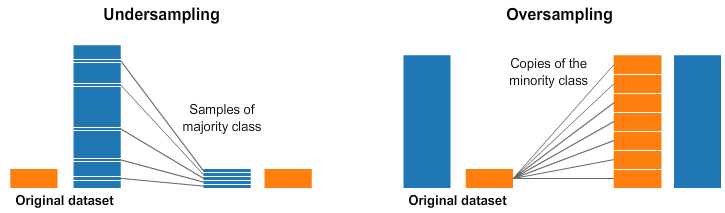

#### Oversampling

In [ ]:
from sklearn.utils import resample

upsample_data = pd.concat([X_train_res, y_train_res], axis=1) # Generar una copia de nuestra data original

majority = upsample_data[upsample_data["Churn"]==0] # Muestra categoria No churn
minority = upsample_data[upsample_data["Churn"]==1] # Muestra categoria Churn

In [ ]:
majority.shape, minority.shape

In [ ]:
minority_upsampled = resample(minority, replace=True, n_samples=3506) # Sobremuestreo

In [ ]:
majority.shape, minority_upsampled.shape

In [ ]:
# Concatenamos nuestro remuestreo en una base consolidada
upsample_data_complete = pd.concat([majority,minority_upsampled])

In [ ]:
# Validamos la nueva proporcion de nuestra target
# ---
upsample_data_complete["Churn"].value_counts()

In [ ]:
upsample_data_complete.info()

#### Undersampling

In [ ]:
from sklearn.utils import resample

upsample_data = pd.concat([X_train_res, y_train_res], axis=1) # Generar una copia de nuestra data original

majority = upsample_data[upsample_data["Churn"]==0] # Muestra categoria No churn
minority = upsample_data[upsample_data["Churn"]==1] # Muestra categoria Churn

In [ ]:
majority.shape, minority.shape

In [ ]:
majority_undersampled = resample(majority, replace=False, n_samples=1252) # Submuestreo

In [ ]:
majority_undersampled.shape, minority.shape

In [ ]:
# Concatenamos nuestro remuestreo en una base consolidada
underample_data_complete = pd.concat([majority_undersampled,minority])

In [ ]:
# Validamos la nueva proporcion de nuestra target
# ---
underample_data_complete["Churn"].value_counts()

#### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Aplicar SMOTE al conjunto de entrenamiento
# Instanciar SMOTE
smote = SMOTE(sampling_strategy=0.6, random_state=42)   # Instanciamos el SMOTE

# Aplicar SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_res, y_train_res)

In [ ]:
Counter(y_train_smote)

## Evaluación de Algoritmos

In [ ]:
# X_train_res, X_test, y_train_res, y_test

In [ ]:
# Seleccionamos el tipo de remuestreo que mejor nos beneficie
# ---------------
#X_train = X_train_res
#y_train = y_train_res

X_train = X_train_smote
y_train = y_train_smote


X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

Importamos las librerías de 5 tipos de algoritmos de clasificación:

1. Árboles de decisión
2. Regresión logística
3. XgBoost
4. Random forest

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve # ROC a diferencia del accuracy te da un valor justo de precision para datos desbalanceados

In [ ]:
# CURVA ROC: Grafico que muestra el rendimiento de un modelo de clasificacion en todos los umbrales donde realiza la clasificacion

# A partir del recall y precision



# AUC (Area bajo la curva) : Indicador

# PARTICION DE LA DATA (TRAIN Y TEST)

# AUC, ACCURACY, F1-SCORE (SEAN SIMILARES TANTO PARA LA DATA DE TRAIN COMO PARA LA DATA DE TEST)

# 1. METRICAS SIMILARES EN TRAIN Y TEST (BUEN AJUSTE DEL MODELO Y RESULTADOS CONSISTENTES)
# 2. METRICAS ALTAS EN TRAIN Y BAJAS EN TEST (SOBREAJUSTE - OVERFITTING)
# 3. METRICAS BAJAS EN TRAIN Y BAJAS EN TEST (SUBAJUSTE)



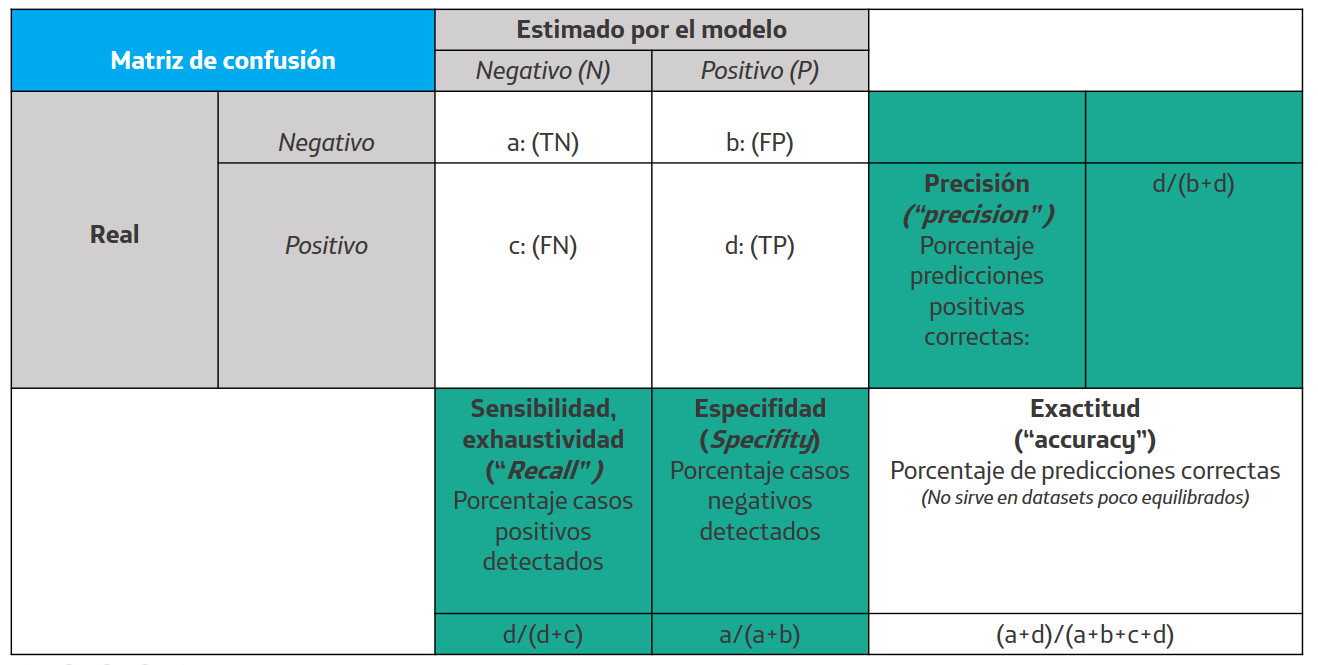

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=5, min_samples_leaf=4)
# DT = DecisionTreeClassifier()

In [ ]:
DT.fit(X_train, y_train)

In [ ]:
y_train_predict_dt =  DT.predict(X_train)
y_test_predict_dt =  DT.predict(X_test)

y_train_predict_proba_dt =  DT.predict_proba(X_train)
y_test_predict_proba_dt =  DT.predict_proba(X_test)

In [ ]:
y_train_predict_dt

In [ ]:
y_train_predict_proba_dt

In [ ]:
# Calcular la matriz de confusión
cm_dt = confusion_matrix(y_train, y_train_predict_dt)
cm_dt

In [ ]:
confusion_matrix_graph(cm_dt)

In [ ]:
(3314+450)/(3314+450+802+192)

In [ ]:
print(metrics.classification_report(y_train,y_train_predict_dt))

In [ ]:
print(metrics.classification_report(y_test,y_test_predict_dt))

In [ ]:
roc_curve_graph(y_train,y_train_predict_proba_dt)

#### Logistic regresion

In [ ]:
LG = LogisticRegression()

In [ ]:
LG.fit(X_train, y_train)

In [ ]:
y_train_predict_lgr =  LG.predict(X_train)
y_test_predict_lgr =  LG.predict(X_test)

y_train_predict_proba_lgr =  LG.predict_proba(X_train)
y_test_predict_proba_lgr =  LG.predict_proba(X_test)

In [ ]:
# Calcular la matriz de confusión
cm_lgr = confusion_matrix(y_train, y_train_predict_lgr)
cm_lgr

In [ ]:
confusion_matrix_graph(cm_lgr)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_train,y_train_predict_lgr))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_test_predict_lgr))

In [ ]:
roc_curve_graph(y_train,y_train_predict_proba_lgr)

#### Random Forest

In [ ]:
# RF = RandomForestClassifier(criterion = "gini", n_estimators=100, random_state=123)
RF = RandomForestClassifier(criterion = "gini",max_depth=5, min_samples_leaf=4, n_estimators=100, random_state=123)
RF

In [ ]:
RF.fit(X_train, y_train)

In [ ]:
y_train_predict_rf =  RF.predict(X_train)
y_test_predict_rf =  RF.predict(X_test)

y_train_predict_proba_rf =  RF.predict_proba(X_train)
y_test_predict_proba_rf =  RF.predict_proba(X_test)

In [ ]:
# Calcular la matriz de confusión
cm_rf = confusion_matrix(y_train, y_train_predict_rf)
cm_rf

In [ ]:
confusion_matrix_graph(cm_rf)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_train,y_train_predict_rf))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_test_predict_rf))

In [ ]:
roc_curve_graph(y_train,y_train_predict_proba_rf)

#### XGBoost

In [ ]:
XGB = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
XGB

In [ ]:
XGB.fit(X_train, y_train)

In [ ]:
y_train_predict_xgb =  LG.predict(X_train)
y_test_predict_xgb =  LG.predict(X_test)

y_train_predict_proba_xgb =  LG.predict_proba(X_train)
y_test_predict_proba_xgb =  LG.predict_proba(X_test)

In [ ]:
# Calcular la matriz de confusión
cm_xgb = confusion_matrix(y_train, y_train_predict_xgb)
cm_xgb

In [ ]:
confusion_matrix_graph(cm_xgb)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_train,y_train_predict_xgb))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_test_predict_xgb))

In [ ]:
roc_curve_graph(y_train,y_train_predict_proba_xgb)

Aparentemente la Regresión Logística y XgBoost me está entregando mejores resultados de predicción del Churn, esto sin realizar ningún ajuste a los modelos.

## Guardando los modelos para un uso posterior

In [ ]:
import pickle

In [ ]:
filename = '/gdrive/MyDrive/Colab Notebooks/practicando Diploma ADS/S4/modelo_LG.sav'
pickle.dump(LG, open(filename, 'wb'))

## Calibración de parámetros



Si durante la evaluación no obtuvimos buenas predicciones y nuestra precisión no es la mínima deseada es posible que tengamos problemas de overfitting (ó underfitting) y deberemos retornar al paso de entrenamiento haciendo antes una nueva configuración de parámetros de nuestro modelo.

Podemos incrementar la cantidad de veces que iteramos nuestros datos de entrenamiento (EPOCHs). Otro parámetro importante es el conocido como «Learning Rate» (taza de aprendizaje) que suele ser un valor que multiplica al gradiente para acercarlo poco a poco al mínimo global (o local) para minimizar el coste de la función. No es lo mismo incrementar nuestros valores en 0,1 unidades que de 0,001 esto puede afectar significativamente el tiempo de ejecución del modelo.

También se puede indicar el máximo error permitido de nuestro modelo. Podemos pasar de tardar unos minutos a horas (y días) en entrenar nuestra máquina. A estos parámetros muchas veces se les llama Hiperparámetros.

Este «tuneo» sigue siendo más un arte que una ciencia y se ira mejorando a medida que experimentamos.

In [ ]:
# Tecnicas de Optimizacion de Hiperparametros :

# 1. Busqueda por cuadricula : Se le entrega al algoritmo una lista de hiperparametros y de diferentes valores con los cuales
# el algoritmo hara varios entrenamientos y te indicara con cual escenario tuvo un mejor performance.(Puede ser mas lento)

# 2. Busqueda aleatorizada : El modelo no va a probar con todas las combinaciones posibles, sino con una muestra de ellas,
# te indicara en cual escenario se obtuvo en mejor performance. (No prueba con todos los escenarios posibles)

# 3. Busqueda bayesiana : Crear un modelo probabilistico a partir de un conjunto de hiperparametros obteniendo un mejor performance.
# Utiliza analisis de regresion para elegir de forma iterativa el mejor conjunto de hiperparametros

In [ ]:
Tree_parameters = {"max_depth": [3,4,5,6],
                   "min_samples_leaf":[1,2,3,4]}

LogReg_parameters = {
    "penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "C":[0.25,0.5,0.75,1.0,1.5,2.0,2.5,3.0,4.0,10.0],
    "solver":["newton-cg", "lbfgs", "sag", "saga"],
    "tol":[0.01,0.001,0.0001,0.00001],
    "warm_start":[True,False]}


RandomForest_parameters = {
    "n_estimators" :[10,15,20,25,30],
    "criterion": ["entropy","gini"],
    "max_depth" : [5,10,15],
    "min_samples_split":[2,4,8,16],
    "max_features":["sqrt","auto","log2"],
    "class_weight" : ["balanced_subsample","balanced"]}

Xgboost_parameters = {"max_depth" : [3,4,5,6],
    "learning_rate" : [0.001,0.0001],
    "booster" : ["gbtree","gblinear","dart"],
    "min_child_weight" : [1,2,3,4]

                     }

Volvemos a entrenar nuestra data con los mismos algoritmos, ahora con el calibramiento de los parámetros:

In [ ]:
from sklearn.model_selection import GridSearchCV # Gridsearch se basa en la tecnica de Busqueda por cuadricula

#### Decision Tree - grid_search

In [ ]:
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=DT, param_grid=Tree_parameters,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1) #
# Ajustar el modelo
grid_search.fit(X_train, y_train)

In [ ]:
# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

In [ ]:
# Obtener el mejor estimador
best_model_DT = grid_search.best_estimator_

In [ ]:
# Obtenemos las predicciones
y_train_predict_dt_gs =  best_model_DT.predict(X_train)
y_test_predict_dt_gs =  best_model_DT.predict(X_test)

y_train_predict_proba_dt_gs =  best_model_DT.predict_proba(X_train)
y_test_predict_proba_dt_gs =  best_model_DT.predict_proba(X_test)

In [ ]:
y_train_predict_dt_gs

In [ ]:
y_train_predict_proba_dt_gs

In [ ]:
# Calcular la matriz de confusión
cm_dt_gs = confusion_matrix(y_train, y_train_predict_dt_gs)
cm_dt_gs

In [ ]:
confusion_matrix_graph(cm_dt_gs)

In [ ]:
print(metrics.classification_report(y_train,y_train_predict_dt_gs))

In [ ]:
print(metrics.classification_report(y_test,y_test_predict_dt_gs))

In [ ]:
roc_curve_graph(y_train,y_train_predict_proba_dt_gs)

#### Logistic regresion - grid_search

In [ ]:
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=LG, param_grid=LogReg_parameters,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
# Ajustar el modelo
grid_search.fit(X_train, y_train)

In [ ]:
# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

In [ ]:
# Obtener el mejor estimador
best_model_LG = grid_search.best_estimator_

In [ ]:
y_train_predict_lgr_gs =  best_model_LG.predict(X_train)
y_test_predict_lgr_gs =  best_model_LG.predict(X_test)

y_train_predict_proba_lgr_gs =  best_model_LG.predict_proba(X_train)
y_test_predict_proba_lgr_gs =  best_model_LG.predict_proba(X_test)

In [ ]:
# Calcular la matriz de confusión
cm_lgr_gs = confusion_matrix(y_train, y_train_predict_lgr)
cm_lgr_gs

In [ ]:
confusion_matrix_graph(cm_lgr_gs)

In [ ]:
print(metrics.classification_report(y_train,y_train_predict_lgr_gs))

In [ ]:
print(metrics.classification_report(y_test,y_test_predict_lgr_gs))

In [ ]:
roc_curve_graph(y_train,y_train_predict_proba_lgr_gs)

#### Random Forest - grid_search

In [ ]:
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=RF, param_grid=RandomForest_parameters,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
# Ajustar el modelo
grid_search.fit(X_train, y_train)

In [ ]:
# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

In [ ]:
# Obtener el mejor estimador
best_model_RF = grid_search.best_estimator_

In [ ]:
y_train_predict_rf_gs =  best_model_RF.predict(X_train)
y_test_predict_rf_gs =  best_model_RF.predict(X_test)

y_train_predict_proba_rf_gs =  best_model_RF.predict_proba(X_train)
y_test_predict_proba_rf_gs =  best_model_RF.predict_proba(X_test)

In [ ]:
# Calcular la matriz de confusión
cm_rf_gs = confusion_matrix(y_train, y_train_predict_rf_gs)
cm_rf_gs

In [ ]:
confusion_matrix_graph(cm_rf_gs)

In [ ]:
print(metrics.classification_report(y_train,y_train_predict_rf_gs))

In [ ]:
print(metrics.classification_report(y_test,y_test_predict_rf_gs))

In [ ]:
roc_curve_graph(y_train,y_train_predict_proba_rf_gs)

## Guardamos el mejor modelo con los mejores parámetros

In [ ]:
import pickle

In [ ]:
filename = '/gdrive/MyDrive/Colab Notebooks/practicando Diploma ADS/S4/best_model_LG.sav'
pickle.dump(best_model_LG, open(filename, 'wb'))

Random Forest tiene un mejor nivel de ROC (75%) vemos claramente que nuestro nivel de ajuste del modelo mejoró respecto a la primera ejecución sin calibramiento de parámetros.

## Llamamos al modelo ganador

In [ ]:
import pickle

In [ ]:
# load the model from disk
filename = '/gdrive/MyDrive/Colab Notebooks/practicando Diploma ADS/S4/best_model_LG.sav'
loaded_model_lg = pickle.load(open(filename, 'rb'))

## Importancia de variables

In [ ]:
# Extraer nombres de las columnas del DataFrame X_train
feature_names = X_train.columns
# Extraer los coeficientes del modelo
coefficients = loaded_model_lg.coef_[0]  # Para regresión logística binaria

# Crear un DataFrame para mostrar la importancia de las variables
importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': coefficients,
    'Importancia_absoluta': np.abs(coefficients)
})

In [ ]:
# Ordenar por importancia absoluta
importance_df = importance_df.sort_values(by='Importancia_absoluta', ascending=False).reset_index(drop=True)

# Mostrar el DataFrame
print(importance_df)

In [ ]:
# Ordenar por importancia absoluta
importance_df = importance_df.sort_values(by='Importancia_absoluta', ascending=False).reset_index(drop=True)
importance_df

## Qué podemos hacer con nuestro modelo?

In [ ]:
#Importamos la data
data_analytics = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/practicando Diploma ADS/S4/Data_Customer_Churn.csv',sep = ';')
data_analytics.head()

In [ ]:
# Realizando las transformaciones necesarias
# ----
data_analytics["SeniorCitizen"] = data_analytics["SeniorCitizen"].astype("str")
data_analytics["TotalCharges"] = data_analytics["TotalCharges"].replace(" ",np.nan)
data_analytics["TotalCharges"] = data_analytics["TotalCharges"].astype("float")
#del data_analytics['tenure']

data_analytics['Churn'] = data_analytics['Churn'].apply(lambda x: 1 if x == "Yes" else 0)

# --
data_analytics = imputar_valores(data_analytics,'TotalCharges',metodo='mediana')

# Creando el set de datos a predecir
# --
columns_num = ['MonthlyCharges','TotalCharges']
columns_cat = ['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod']

df_analytics = pd.concat([data_analytics[columns_num],pd.get_dummies(data = data_analytics[columns_cat]), data_analytics['Churn']], axis=1)
df_analytics.info()

In [ ]:
# Al dataset o set de entrenamiento le retiramos la variable dependiente o target
X = df_analytics.drop("Churn",axis=1) # covariables
Y = df_analytics['Churn'] # target

In [ ]:
original_feature_names = loaded_model_lg.feature_names_in_
X = X[original_feature_names]
X.columns

In [ ]:
# Obtenemos la predicción
# -----
y_predict =  loaded_model_lg.predict(X)
y_predict_proba =  loaded_model_lg.predict_proba(X)

In [ ]:
# Incorporamos la predicción a nuestro set de datos
# ----
data_analytics['Y_pred'] = y_predict
data_analytics[['prob_class_0','prob_class_1']] = y_predict_proba
# --
data_analytics.head()

In [ ]:
data_analytics_campaña = data_analytics[(data_analytics['Churn'] == 0) & (data_analytics['Y_pred'] == 1)]
data_analytics_campaña.head(5)

In [ ]:
# Creamos una nueva columna de rango
# ----------------
rangos = pd.cut(data_analytics_campaña['prob_class_1'], bins=5, labels=["Muy Bajo", "Bajo", "Medio", "Alto", "Muy Alto"])

# --
# Añadir la nueva variable al DataFrame
data_analytics_campaña['Rango_prob_class_1'] = rangos

In [ ]:
data_analytics_campaña.head()

In [ ]:
# Calcular frecuencias absolutas y relativas
frecuencias_absolutas = data_analytics_campaña['Rango_prob_class_1'].value_counts()
frecuencias_relativas = data_analytics_campaña['Rango_prob_class_1'].value_counts(normalize=True) * 100

# Calcular la probabilidad mínima y máxima por rango
prob_min = data_analytics_campaña.groupby('Rango_prob_class_1')['prob_class_1'].min()
prob_max = data_analytics_campaña.groupby('Rango_prob_class_1')['prob_class_1'].max()

# Crear DataFrame con las métricas calculadas
tabla_frecuencias = pd.DataFrame({
    'Frecuencia Absoluta': frecuencias_absolutas,
    'Frecuencia Relativa (%)': frecuencias_relativas,
    'Probabilidad Mínima': prob_min,
    'Probabilidad Máxima': prob_max
})

# Ordenar por categorías predefinidas
orden_rangos = ["Muy Bajo", "Bajo", "Medio", "Alto", "Muy Alto"]
tabla_frecuencias = tabla_frecuencias.reindex(orden_rangos)

# Mostrar tabla
tabla_frecuencias


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creamos el gráfico de cajas
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rango_prob_class_1', y='TotalCharges', data=data_analytics_campaña)

plt.title('Distribución de TotalCharges por Rango de Probabilidad de Clase 1')
plt.xlabel('Rango de Probabilidad de Clase 1')
plt.ylabel('TotalCharges')

# Mostrar el gráfico
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=data_analytics_campaña, x='Rango_prob_class_1', y='tenure', estimator=np.mean, palette='viridis')
plt.title("Promedio de Tenure por Rango de Probabilidad")
plt.xlabel("Rango de Probabilidad")
plt.ylabel("Promedio de Tenure (meses)")
plt.xticks(rotation=0)
plt.show()

Clientes con menos tenure (meses de permanencia en la empresa) suelen tener mayor probabilidad de abandono.

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data_analytics_campaña, x='Rango_prob_class_1', hue='Contract', palette='Set2')
plt.title("Distribución de Tipo de Contrato por Rango de Probabilidad")
plt.xlabel("Rango de Probabilidad")
plt.ylabel("Cantidad de Clientes")
plt.legend(title="Contrato")
plt.xticks(rotation=0)
plt.show()

Clientes con contratos de mes a mes suelen tener más probabilidad de churn.

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data_analytics_campaña, x='Rango_prob_class_1', hue='InternetService', palette='pastel')
plt.title("Distribución de Tipo de Internet por Rango de Probabilidad")
plt.xlabel("Rango de Probabilidad")
plt.ylabel("Cantidad de Clientes")
plt.legend(title="Internet Service")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# uploaded = files.upload()
data_analytics_new= pd.read_csv('/gdrive/MyDrive/Colab Notebooks/practicando Diploma ADS/S4/Data_Customer_Churn_new.csv',sep = ';')
data_analytics_new.head()

In [ ]:
# Realizando las transformaciones necesarias
# ----
data_analytics_new["SeniorCitizen"] = data_analytics_new["SeniorCitizen"].astype("str")
data_analytics_new["TotalCharges"] = data_analytics_new["TotalCharges"].replace(" ",np.nan)
data_analytics_new["TotalCharges"] = data_analytics_new["TotalCharges"].astype("float")


# --
data_analytics_new = imputar_valores(data_analytics_new,'TotalCharges',metodo='mediana')

# Creando el set de datos a predecir
# --
columns_num = ['MonthlyCharges','TotalCharges']
columns_cat = ['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod']

df_analytics_new = pd.concat([data_analytics_new[columns_num],pd.get_dummies(data = data_analytics_new[columns_cat])], axis=1)
df_analytics_new.info()

In [ ]:
original_feature_names = loaded_model_lg.feature_names_in_
df_analytics_new = df_analytics_new[original_feature_names]
df_analytics_new.columns

In [ ]:
# Obtenemos la predicción
# -----
y_predict_new =  loaded_model_lg.predict(df_analytics_new)
y_predict_proba_new =  loaded_model_lg.predict_proba(df_analytics_new)

In [ ]:
# Incorporamos la predicción a nuestro set de datos
# ----
data_analytics_new['y_pred'] = y_predict_new
data_analytics_new[['prob_class_0','prob_class_1']] = y_predict_proba_new
# --
data_analytics_new.head()

Podemos usar los rangos anteriores para priorizar clientes con posible churn

In [ ]:
tabla_frecuencias

In [ ]:
# Crear un diccionario con los rangos de tabla_frecuencias
rangos = tabla_frecuencias[['Probabilidad Mínima', 'Probabilidad Máxima']].reset_index()

# Función para asignar rangos
def asignar_rango(probabilidad):
    for _, row in rangos.iterrows():
        if row['Probabilidad Mínima'] <= probabilidad <= row['Probabilidad Máxima']:
            return row['Rango_prob_class_1']
    return None  # En caso de que no caiga en ningún rango

# Aplicar la función a la nueva base de datos
data_analytics_new["Rango_prob_class_1"] = data_analytics_new["prob_class_1"].apply(asignar_rango)

# Verificar resultado
data_analytics_new.head()


In [ ]:
# Calcular frecuencias absolutas y relativas
frecuencias_absolutas = data_analytics_new['Rango_prob_class_1'].value_counts()
frecuencias_relativas = data_analytics_new['Rango_prob_class_1'].value_counts(normalize=True) * 100

# Calcular la probabilidad mínima y máxima por rango
prob_min = data_analytics_new.groupby('Rango_prob_class_1')['prob_class_1'].min()
prob_max = data_analytics_new.groupby('Rango_prob_class_1')['prob_class_1'].max()

# Crear DataFrame con las métricas calculadas
tabla_frecuencias = pd.DataFrame({
    'Frecuencia Absoluta': frecuencias_absolutas,
    'Frecuencia Relativa (%)': frecuencias_relativas,
    'Probabilidad Mínima': prob_min,
    'Probabilidad Máxima': prob_max
})

# Ordenar por categorías predefinidas
orden_rangos = ["Muy Bajo", "Bajo", "Medio", "Alto", "Muy Alto"]
tabla_frecuencias = tabla_frecuencias.reindex(orden_rangos)

# Mostrar tabla
tabla_frecuencias

## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
# Validación cruzada
scores = cross_val_score(loaded_model_lg, X_train, y_train, cv=10, scoring='roc_auc')

print(f"Score Validación Cruzada: {scores.mean()}")

In [ ]:
# Mostrando los 5 valores de socre obtenidos
print("Valores de score en cada fold de la validación cruzada:")
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score:.4f}")

In [ ]:
# Crear la figura con subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot en el primer subplot
sns.boxplot(x=scores, color="skyblue", ax=axes[0], width=0.3, fliersize=5)
axes[0].set_title("Boxplot de Scores")
axes[0].set_xlabel("Score")

# Histograma con KDE en el segundo subplot
sns.histplot(scores, bins=5, kde=True, color="blue", alpha=0.6, ax=axes[1])
axes[1].set_title("Distribución de Scores")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Frecuencia")

# Ajustar el diseño
plt.tight_layout()
plt.show()


**1. Boxplot (Izquierda):**

- Se observa que la dispersión de los scores no es muy grande, lo que indica que el modelo es estable en diferentes folds de la validación cruzada.

- No hay valores atípicos significativos, lo cual es una buena señal de consistencia en el rendimiento.

**2. Histograma con KDE (Derecha):**

- Los scores tienden a agruparse en valores altos, lo que sugiere que el modelo tiene un buen desempeño general.

- Sin embargo, hay cierta variabilidad entre los folds, lo que podría indicar que en algunos casos el modelo rinde mejor que en otros.

**3. Conclusión**
- El modelo tiene un desempeño alto y estable, ya que los scores están en un rango elevado.

- Hay una ligera variabilidad, pero sin valores extremadamente bajos o atípicos.

- Se puede revisar qué características de los datos podrían estar afectando las pequeñas variaciones entre los folds.